In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys
import pandas as pd
from src import SimGame as sg
from src import helperfunctions as hf

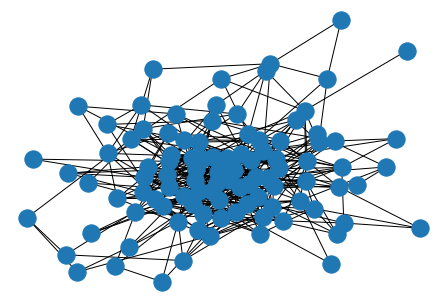

In [2]:
def average_degree(system,control,budget):
    return abs(np.sum([system.graph.degree[i]*con for i,con in enumerate(control)])/budget)



sizes = [50,50] # sizes of blocks
probs = [[0.2, 0.05], [0.05, 0.05]]
G = nx.stochastic_block_model(sizes, probs, seed=0)

nx.draw(G)

# G.graph['partition'][1] get nodes from 2nd stochastic block


beta_crit = hf.crit_b(nx.to_numpy_matrix(G))

In [3]:
import networkx as nx 
import numpy as np
import math
from tqdm import tqdm
import numba
from numba.experimental import jitclass
from numba import jit




steadyspec = [
    ('adj_matrix',numba.float64[:,:]),
    ('graph_size',numba.int32),
    ('background_field',numba.float64[:]),
    ('fixed_point_iter',numba.int32),
    ('fp_tol_fac',numba.float64),
]


@jitclass(steadyspec)
class steady_state(object):
    def __init__(self,adj_matrix,fixed_point_iter=10000,fp_tol_fac=1e-6):

        self.adj_matrix = adj_matrix
        self.graph_size = self.adj_matrix.shape[0]
        self.fixed_point_iter=fixed_point_iter
        self.fp_tol_fac=fp_tol_fac


    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = self.adj_matrix[i].dot(m)
        term = math.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term

    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(self.graph_size):
            m_new[i]=self.single_mag(i,m_old,beta,field)
        return m_new

    def aitken_method(self,mag0,beta,field):      
        mag1=self.magnetisation(mag0,beta,field)
        for i in range(self.fixed_point_iter):     
            mag2=self.magnetisation(mag1,beta,field)   
            if ((mag0+mag2-2*mag1)!=0).all():
                mag_d = mag0 - (mag1-mag0)**2/(mag0+mag2-2*mag1) 
            else:
                mag_d = mag1

            if abs(np.sum(mag0)-np.sum(mag_d))<self.fp_tol_fac: 
                break
            mag0=mag1
            mag1=mag2
            if i+1==self.fixed_point_iter:
                mag_d = mag1

        return mag_d

@jit(nopython=True) 
def isclose(a,b):
    return abs(a-b) <= max(1e-9 * max(abs(a), abs(b)), 1e-5)


@jit(nopython=True) 
def susc_grad(beta,mag,adj_matrix):
    D=np.identity(mag.shape[0])*np.array([(1-i**2) for i in mag]) 
    inv = np.linalg.inv(np.identity(mag.shape[0])-beta*D.dot(adj_matrix))
    susc_matrix = beta*inv.dot(D)
    gradient = np.sum(susc_matrix,axis=1).flatten()

    return gradient

def mag_grad(beta,mag,adj_matrix):
    if np.all([isclose(i,j) for i,j in zip(mag,np.ones(mag.shape[0]))]):
        return np.zeros(len(mag))
    else:
        return susc_grad(beta,mag,adj_matrix)



@jit(nopython=True)
def projection_simplex_sort(v, z):
    n_features = v.shape[0]
    v = np.abs(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


@jit(nopython=True) 
def lr_1(x,iim_iter=5000):
    return np.exp(-x/(0.1*iim_iter))

@jit(nopython=True) 
def lr_2(x,iim_iter=5000):
    return np.exp(-x/(0.1*iim_iter))

@jit(nopython=True) 
def adam(grad,it,typ,ms,vs,iim_iter,beta1=0.9,beta2=0.999,eps=0.1):
    if typ=='pos':
        lr=lr_1(it)
    elif typ=='neg':
        lr=lr_2(it)
    ms_new = beta1 * ms + (1.0 - beta1) * grad
    vs_new = beta2 * vs + (1.0 - beta2) * grad**2
    mhat = ms_new / (1.0 - beta1**(it+1))
    vhat = vs_new / (1.0 - beta2**(it+1))
    ms = ms_new
    vs = vs_new
    change = lr* mhat/(np.sqrt(vhat) + eps)
    return change,ms,vs

class mf_ising_system():
    def __init__(self,graph,background_field,iim_iter=10000,iim_tol_fac=1e-3):

        self.graph=graph
        self.adj_matrix = nx.to_numpy_matrix(graph).astype(np.float64)
        self.graph_size = self.adj_matrix.shape[0]
        self.background_field = background_field.astype(np.float64)
        self.iim_iter=iim_iter
        self.iim_tol_fac = iim_tol_fac
        

    def positive_agent(self,mag_i,it,pos_budget,beta):
        mag_i_grad = mag_grad(beta,mag_i,self.adj_matrix)
        control_field = self.control_field_history_pos[-1]
        change,ms,vs = adam(mag_i_grad,it,'pos',self.ms_pos,self.vs_pos,self.iim_iter)
        self.ms_pos=ms
        self.vs_pos=vs
        control_field_update = control_field  + change
        control_field_new = projection_simplex_sort(control_field_update.T,pos_budget)
        control_field_new = control_field_update
        self.control_field_history_pos.append(control_field_new)
        return control_field_new,mag_i_grad
    
    def negative_agent(self,mag_i,it,neg_budget,beta):
        mag_i = -1.0*mag_i
        mag_i_grad = -mag_grad(beta,mag_i,self.adj_matrix)
        control_field = self.control_field_history_neg[-1]
        change,ms,vs=adam(mag_i_grad,it,'neg',self.ms_neg,self.vs_neg,self.iim_iter)
        self.ms_neg=ms
        self.vs_neg=vs
        control_field_update = control_field + change
        control_field_new = projection_simplex_sort(control_field_update.T,neg_budget)
        control_field_new = control_field_update
        self.control_field_history_neg.append(control_field_new)
        
        return control_field_new,mag_i_grad
        
    def second_partial_dffs(self,state,mag_ii,tot_field,beta,a=1e-5):
        update = a*np.ones(self.graph_size)
        upper_change=tot_field+update
        mag_plus= -state.aitken_method(mag_ii,beta,upper_change)
        grad_plus = -mag_grad(beta,mag_plus,self.adj_matrix)

        lower_change = tot_field-update
        mag_minus= -state.aitken_method(mag_ii,beta,lower_change)
        grad_minus = -mag_grad(beta,mag_minus,self.adj_matrix)
        second_total_grad =  (grad_plus - grad_minus)/(2*update) # central difference formula
        curv_player_neg = - second_total_grad # minus because product rule : H_pos = H_pos - H_neg
        curv_player_pos = curv_player_neg
        return np.array([curv_player_pos,curv_player_neg])
    
    def init_lists(self):
        self.control_field_history_pos =[]
        self.control_field_history_neg = []
        self.mag_history = []
        self.pos_gradient_history=np.zeros((self.iim_iter,self.graph_size))
        self.neg_gradient_history=np.zeros((self.iim_iter,self.graph_size))
        
        self.ms_pos = np.zeros(self.graph_size,dtype=np.float64)
        self.vs_pos = np.zeros(self.graph_size,dtype=np.float64)
        self.ms_neg = np.zeros(self.graph_size,dtype=np.float64)
        self.vs_neg = np.zeros(self.graph_size,dtype=np.float64)
        

    def MF_IIM(self,pos_budget,neg_budget,beta,init_alloc='random',progress=True):
 
        if isinstance(init_alloc,(np.ndarray, np.generic)):
            control_field_pos = init_alloc[0,:]
            control_field_neg = init_alloc[1,:] 
        elif isinstance(init_alloc,str):  
            if  init_alloc=='aligned':
                control_field_pos =( pos_budget /self.graph_size)*np.ones(self.graph_size)
                control_field_neg = ( neg_budget /self.graph_size)*np.ones(self.graph_size)
            elif init_alloc=='random':
                control_field_pos  = np.random.dirichlet(np.ones(self.graph_size))*pos_budget
                control_field_neg  = np.random.dirichlet(np.ones(self.graph_size))*neg_budget
  
        init_mag = np.array([np.random.choice([-1,1]) for i in range(self.graph_size)]).astype(np.float64)

        self.init_lists()

        self.control_field_history_pos.append(control_field_pos)
        self.control_field_history_neg.append(control_field_neg)
        
        
        state = steady_state(self.adj_matrix)
        self.state=state

        tot_field = control_field_pos-control_field_neg
        
        mag_i = state.aitken_method(init_mag,beta,tot_field)
        self.mag_history.append(mag_i)

        for it in tqdm(range(self.iim_iter)) if progress else range(self.iim_iter):
            
            gradients=[]
            if pos_budget!=0:
                control_pos,pos_gradient = self.positive_agent(mag_i,it,pos_budget,beta)
                tot_field +=control_pos
                self.pos_gradient_history[it]=pos_gradient
                gradients.append(pos_gradient)

            if neg_budget!=0:
                control_neg,neg_gradient = self.negative_agent(mag_i,it,neg_budget,beta)
                tot_field-=control_neg
                self.neg_gradient_history[it]=neg_gradient
                gradients.append(neg_gradient)

            mag_ii= state.aitken_method(mag_i,beta,tot_field)
            
            self.mag_history.append(mag_ii)
            
            # if (all(np.abs(self.control_field_history_pos[-1]-self.control_field_history_pos[-2])<self.iim_tol_fac) and 
            #     all(np.abs(self.control_field_history_neg[-1]-self.control_field_history_neg[-2])<self.iim_tol_fac)):
            #     break
            if np.all([(abs(gradient)<self.iim_tol_fac).all() for gradient in gradients]):
                second_dffs=self.second_partial_dffs(state,mag_ii,tot_field,beta)
                if (second_dffs[0]<0).all() and (second_dffs[1]<0).all():
                    break
            
            mag_i=mag_ii
            tot_field=0.0
        if it==self.iim_iter-1:
            print('Failed to converge after {} iterations'.format(self.iim_iter))
            final_mag = mag_ii
            
        elif it < self.iim_iter-1:
            final_mag = mag_ii
        
        self.control_field_history_pos = np.array(self.control_field_history_pos)
        self.control_field_history_neg = np.array(self.control_field_history_neg)
        self.mag_history = np.array(self.mag_history)

        return self.control_field_history_pos[-1],self.control_field_history_neg[-1],final_mag


In [4]:

def init_allocation(budget_pos,budget_neg):
    pos_share_tight = np.random.uniform(0,1)
    neg_share_tight=np.random.uniform(0,1)

    a_pos = np.random.dirichlet(np.ones(50))*pos_share_tight*budget_pos 
    b_pos =np.random.dirichlet(np.ones(50))*(1.0-pos_share_tight)*budget_pos 

    init_pos = np.concatenate([a_pos,b_pos])

    a_neg = np.random.dirichlet(np.ones(50))*neg_share_tight*budget_neg
    b_neg =np.random.dirichlet(np.ones(50))*(1.0-neg_share_tight)*budget_neg 

    init_neg =  np.concatenate([a_neg,b_neg])

    init_alloc = np.column_stack([init_pos,init_neg]).T
    return init_alloc


def average_degree(system,control,budget):
    return np.sum([system.graph.degree[i]*con for i,con in enumerate(control)])/budget



In [5]:

X = dict.fromkeys([0,1],None)
Y= dict.fromkeys([0,1],None)

In [6]:
b = np.zeros(len(G.nodes.keys()))
budget_pos=20.0
budget_neg=20.0


system = mf_ising_system(G,b,iim_iter=50000,iim_tol_fac=2*1e-4)


beta=1.0

iters=5
pos_degrees=[]
neg_degrees=[]

for i in range(iters):
    init_external=init_allocation(budget_pos,budget_neg)
    control_pos,control_neg,mag=system.MF_IIM(budget_pos,budget_neg,beta,init_alloc=init_external)
    control_pos_cons=np.array([projection_simplex_sort(control,budget_pos) for control in system.control_field_history_pos])
    control_neg_cons = np.array([projection_simplex_sort(control,budget_neg) for control in system.control_field_history_neg])
    temp_pos=[]
    temp_neg=[]
    for idx in range(0,control_neg_cons.shape[0]):
        pos_degree = average_degree(system,control_pos_cons[idx],budget_pos)
        neg_degree = average_degree(system,control_neg_cons[idx],budget_neg)
        temp_pos.append(pos_degree)
        temp_neg.append(neg_degree)
    
    pos_degrees.append(temp_pos)
    neg_degrees.append(temp_neg)

<string>:3: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  0%|▏                                                                          | 142/50000 [01:51<10:53:05,  1.27it/s]


KeyboardInterrupt: 

In [42]:
if beta==0.2:
    X[0]=pos_degrees
    Y[0]=neg_degrees
if beta==1.0:
    X[1]=pos_degrees
    Y[1]=neg_degrees
       


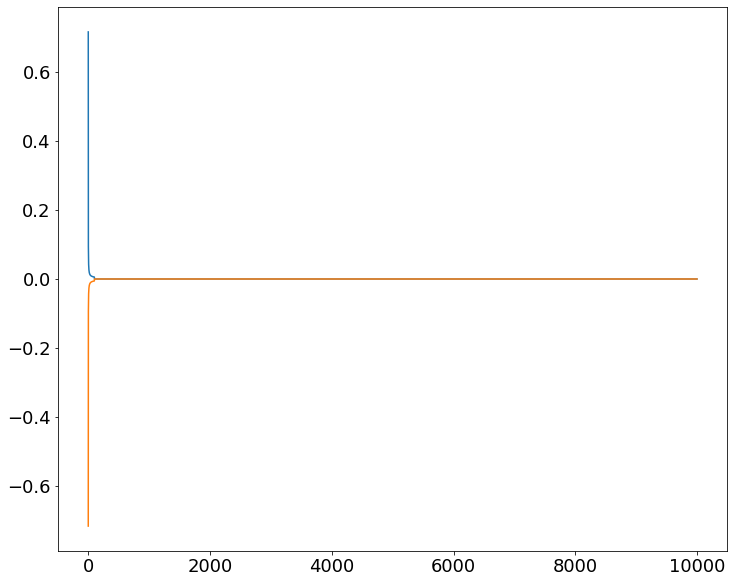

In [59]:
s=np.array(system.pos_gradient_history)

v=np.array(system.neg_gradient_history)


plt.plot(np.sum(s,axis=1))
plt.plot(np.sum(v,axis=1))

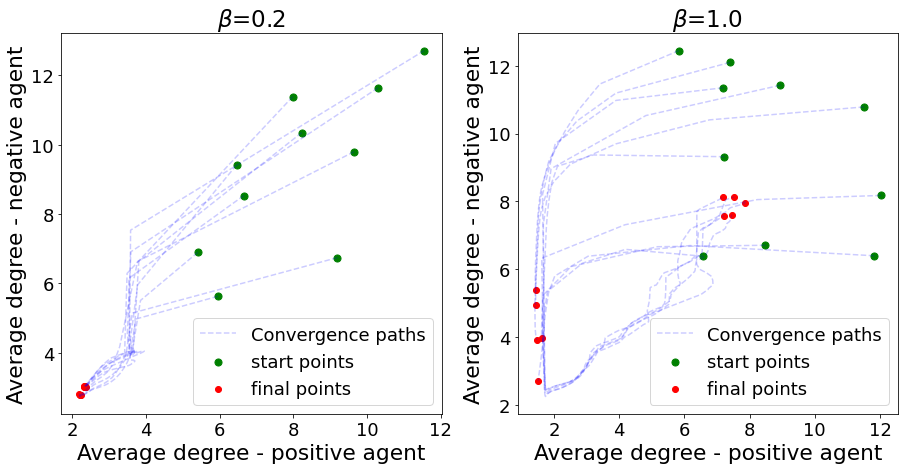

In [61]:
import matplotlib

n=1

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':(12,10),'axes.labelsize': 'large',
                           'axes.titlesize':20})
s=23
fig,ax=plt.subplots(figsize=(15,7),ncols=2)

for idx,run in enumerate(X[0]):
    
    ax[0].plot(run[::n],Y[0][idx][::n],label='Convergence paths',c='blue',linestyle='dashed',alpha=0.2)
    ax[0].set_xlabel('Average degree - positive agent')
    ax[0].set_ylabel('Average degree - negative agent')
    ax[0].scatter(run[0],Y[0][idx][0],c='green',label='start points',s=50)
    ax[0].scatter(run[-1],Y[0][idx][-1],c='red',label='final points')

    hand, labl = ax[0].get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
        if l not in lablout:
            lablout.append(l)
            handout.append(h)
    ax[0].legend(handout, lablout,loc='best')
    ax[0].set_title(r'$\beta$=0.2',fontsize=s)

for idx,run in enumerate(X[1]):
    
    ax[1].plot(run[::n],Y[1][idx][::n],label='Convergence paths',c='blue',linestyle='dashed',alpha=0.2)
    ax[1].set_xlabel('Average degree - positive agent')
    ax[1].set_ylabel('Average degree - negative agent')
    ax[1].scatter(run[0],Y[1][idx][0],c='green',label='start points',s=50)
    ax[1].scatter(run[-1],Y[1][idx][-1],c='red',label='final points')

    hand, labl = ax[1].get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
        if l not in lablout:
            lablout.append(l)
            handout.append(h)
    ax[1].legend(handout, lablout,loc='best')
    ax[1].set_title(r'$\beta$=1.0',fontsize=s)



In [ ]:
budget_pos=5.0
b = np.zeros(len(G.nodes.keys()))

budget_neg=20.0


beta_min = 0.5*beta_crit 
beta_max = 3*beta_crit 

beta_list = np.logspace(np.log10(beta_min),np.log10(beta_max),num=10,endpoint=True,base=10)
control_history_pos=np.zeros((len(beta_list),2))
control_history_neg=np.zeros((len(beta_list),2))
mag_history = np.zeros((len(beta_list),100))

# normal_params = {'lr_1':lr_1,'lr_2':lr_2,'iim_iter':1000,'iim_tol_fac':1e-3,'fixed_point_iter':5000,
#                          'fp_tol_fac':1e-3,'optimiser_type':'sgdm','momentum':0.7}


params = {'optimiser_type':'adam','lr_1':lr_1,'lr_2':lr_1,'beta1':0.8,'beta2':0.999,'eps':0.1}

for i,beta in enumerate(beta_list):
    
    system = sg.mf_ising_system(G,b,iim_iter=1000,fixed_point_iter=int(5*1e5),iim_tol_fac=1e-1,**params)
    control_pos,control_neg,final_mag=system.MF_IIM(budget_pos,budget_neg,beta)
    
    block1,block2 = np.sum(control_pos[:50]),np.sum(control_pos[50:])
    control_history_pos[i]=np.array([block1,block2])

    block1,block2 = np.sum(control_neg[:50]),np.sum(control_neg[50:])
    control_history_neg[i]=np.array([block1,block2])
    
    mag_history[i]=final_mag
     
    if i%1==0:
        print(i,beta)

print('FINISHED')    

Failed to converge after 1000 iterations
0 0.04285309672488253
Failed to converge after 1000 iterations
1 0.05229298838887463
Failed to converge after 1000 iterations
2 0.06381234598271548
Failed to converge after 1000 iterations
3 0.07786924452541158


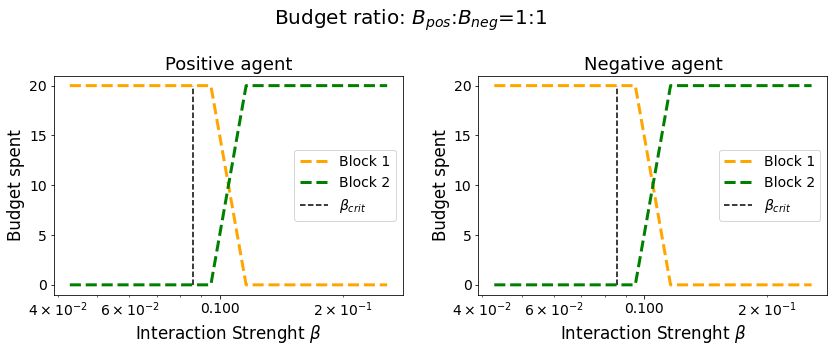

In [8]:
import matplotlib


matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(12,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})

# to_del =[80,81]
# control_history_edit= np.delete(control_history,to_del,axis=0)
# beta_list_edit = np.delete(beta_list,to_del,axis=0)


fig,ax = plt.subplots(ncols=2)

ax[0].plot(beta_list,control_history_pos[:,0],c='orange',label='Block 1',linestyle='dashed',linewidth=3)
ax[0].plot(beta_list,control_history_pos[:,1],c='green',label='Block 2',linestyle='dashed',linewidth=3)

ax[0].set_xscale(value='log')

ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].set_ylabel('Budget spent')
ax[0].vlines(beta_crit,ymin=0,ymax=20,linestyles='dashed',color='black',label=r'$\beta_{crit}$')
ax[0].set_xlabel(r'Interaction Strenght $\beta$')
ax[0].set_title('Positive agent')
ax[0].legend()


ax[1].plot(beta_list,control_history_neg[:,0],c='orange',label='Block 1',linestyle='dashed',linewidth=3)
ax[1].plot(beta_list,control_history_neg[:,1],c='green',label='Block 2',linestyle='dashed',linewidth=3)

ax[1].set_xscale(value='log')

ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].set_ylabel('Budget spent')
ax[1].vlines(beta_crit,ymin=0,ymax=20,linestyles='dashed',color='black',label=r'$\beta_{crit}$')
ax[1].set_xlabel(r'Interaction Strenght $\beta$')
ax[1].set_title('Negative agent')
ax[1].legend()


fig.suptitle(r'Budget ratio: $B_{pos}$:$B_{neg}$=1:1',fontsize=20)
plt.tight_layout()
plt.show()


In [ ]:
budget_pos=5.0
budget_neg=10.0


lr_1 = lambda x,maxiter : 5*np.exp(-x/(0.9*maxiter))


lr_2 = lambda x,maxiter : np.exp(-x/(0.9*maxiter))


beta=0.2
b = np.zeros(len(G.nodes.keys()))
iters=10


params = {'optimiser_type':'adam','lr_1':lr_1,'lr_2':lr_2,'beta1':0.9,'beta2':0.999,'eps':10.0}

controlArr = []
for i in range(iters):
    system = sg.mf_ising_system(G,b,iim_iter=5000,fixed_point_iter=int(5*1e5),iim_tol_fac=1e-3,**params)
    init_external=init_allocation(budget_pos,budget_neg)
    control_pos,control_neg,mag=system.MF_IIM(budget_pos,budget_neg,beta,init_alloc=init_external)
    controlArr.append(np.array(system.mag_delta_history))


Failed to converge after 5000 iterations


In [ ]:
x=np.sum(np.array(system.mag_delta_history),axis=1)

y = np.std(np.array(system.mag_delta_history),axis=1)


In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20,'figure.figsize':(12,10),'axes.labelsize': 'large',
                           'axes.titlesize':18})


fig,ax=plt.subplots()

xarray=np.arange(0,len(x),1)
ax.plot(x,label='Total Magnetisation')
ax.fill_between(xarray,x+y,x-y,**{'color':'blue','alpha':0.5})


ax.legend()

        
pos_string = '$Budget_{pos}$'
neg_string = '$Budget_{neg}$'
ax.set_title(r'Overall nodes magnetisation'+'\n' +'for {}={} {}={}'.format(pos_string,budget_pos,neg_string,budget_neg),fontsize=22)
ax.set_xlabel('Iterations')
ax.set_ylabel('Magnetisation sum')